# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

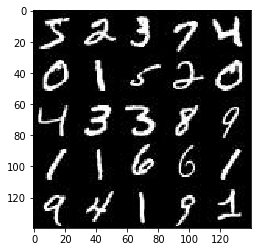

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

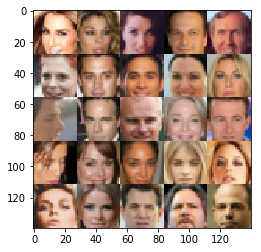

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use GPU:0

config = tf.ConfigProto()
config.gpu_options.allow_growth=True # Increase accroding to the usage
#config.gpu_options.per_process_gpu_memory_fraction = 0.4 # Using memory according to the percentage : 40% 

with tf.Session(config=config) as sess :
    # Check TensorFlow Version
    assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
    print('TensorFlow Version: {}'.format(tf.__version__))

    # Check for a GPU
    if not tf.test.gpu_device_name():
        warnings.warn('No GPU found. Please use a GPU to train your neural network.')
    else:
        print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.5
        # Input layer is 28 * 28 * 3
        
        # x1 : 14 * 14 * 64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # x2 : 7 * 7 * 28
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # x3 : 4 * 4 * 256
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha = 0.2
        
        # Reshpae to 7 * 7 * 256
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x2 = tf.layers.batch_normalization(x1, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14 * 14 * 128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 28 * 28 * 3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')   
    return logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function  
    d_model_real, d_logits_real = discriminator(input_real)
    
    g_model = generator(input_z, out_channel_dim)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))   
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))   
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
       
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if step % show_steps == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, Step {} ...".format(epoch_i+1, epochs, step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % (show_steps * 5) == 0:                
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                step += 1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10, Step 0 ... Discriminator Loss: 2.3539... Generator Loss: 0.1473


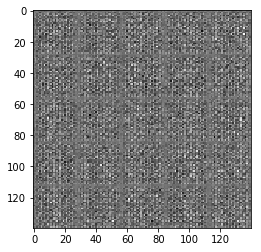

Epoch 1/10, Step 50 ... Discriminator Loss: 0.2595... Generator Loss: 3.0801
Epoch 1/10, Step 100 ... Discriminator Loss: 0.3839... Generator Loss: 2.3546
Epoch 1/10, Step 150 ... Discriminator Loss: 0.1903... Generator Loss: 2.4090
Epoch 1/10, Step 200 ... Discriminator Loss: 2.1428... Generator Loss: 3.3886
Epoch 1/10, Step 250 ... Discriminator Loss: 0.9587... Generator Loss: 0.6240
Epoch 1/10, Step 300 ... Discriminator Loss: 0.3912... Generator Loss: 1.9846
Epoch 1/10, Step 350 ... Discriminator Loss: 0.3215... Generator Loss: 1.7504
Epoch 1/10, Step 400 ... Discriminator Loss: 0.2707... Generator Loss: 2.3693
Epoch 1/10, Step 450 ... Discriminator Loss: 0.1896... Generator Loss: 2.3656
Epoch 2/10, Step 500 ... Discriminator Loss: 0.1385... Generator Loss: 2.5078


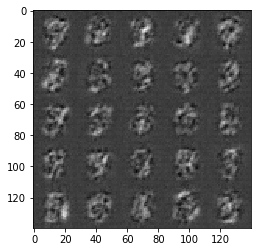

Epoch 2/10, Step 550 ... Discriminator Loss: 0.1342... Generator Loss: 2.5098
Epoch 2/10, Step 600 ... Discriminator Loss: 0.1229... Generator Loss: 3.1006
Epoch 2/10, Step 650 ... Discriminator Loss: 0.9837... Generator Loss: 1.0813
Epoch 2/10, Step 700 ... Discriminator Loss: 1.0606... Generator Loss: 1.3460
Epoch 2/10, Step 750 ... Discriminator Loss: 0.3099... Generator Loss: 1.9401
Epoch 2/10, Step 800 ... Discriminator Loss: 0.1739... Generator Loss: 2.0998
Epoch 2/10, Step 850 ... Discriminator Loss: 0.3749... Generator Loss: 1.3179
Epoch 2/10, Step 900 ... Discriminator Loss: 0.0910... Generator Loss: 2.7078
Epoch 3/10, Step 950 ... Discriminator Loss: 0.0575... Generator Loss: 3.3456
Epoch 3/10, Step 1000 ... Discriminator Loss: 0.0782... Generator Loss: 2.9473


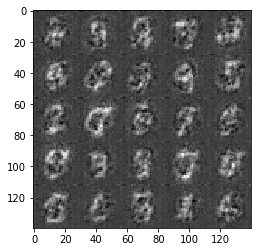

Epoch 3/10, Step 1050 ... Discriminator Loss: 0.1210... Generator Loss: 2.3857
Epoch 3/10, Step 1100 ... Discriminator Loss: 0.0459... Generator Loss: 3.6753
Epoch 3/10, Step 1150 ... Discriminator Loss: 0.0125... Generator Loss: 5.5380
Epoch 3/10, Step 1200 ... Discriminator Loss: 0.0443... Generator Loss: 3.4943
Epoch 3/10, Step 1250 ... Discriminator Loss: 0.0292... Generator Loss: 7.7353
Epoch 3/10, Step 1300 ... Discriminator Loss: 0.6384... Generator Loss: 1.5099
Epoch 3/10, Step 1350 ... Discriminator Loss: 0.6353... Generator Loss: 1.0481
Epoch 3/10, Step 1400 ... Discriminator Loss: 0.1232... Generator Loss: 2.9242
Epoch 4/10, Step 1450 ... Discriminator Loss: 0.1059... Generator Loss: 2.7277
Epoch 4/10, Step 1500 ... Discriminator Loss: 0.0529... Generator Loss: 3.6519


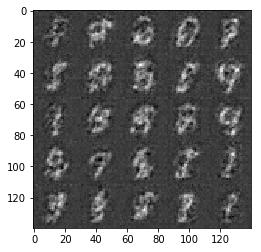

Epoch 4/10, Step 1550 ... Discriminator Loss: 0.0479... Generator Loss: 3.6086
Epoch 4/10, Step 1600 ... Discriminator Loss: 0.0134... Generator Loss: 7.2469
Epoch 4/10, Step 1650 ... Discriminator Loss: 0.0267... Generator Loss: 4.1022
Epoch 4/10, Step 1700 ... Discriminator Loss: 0.0503... Generator Loss: 3.3593
Epoch 4/10, Step 1750 ... Discriminator Loss: 1.9943... Generator Loss: 0.8317
Epoch 4/10, Step 1800 ... Discriminator Loss: 0.9280... Generator Loss: 0.6895
Epoch 4/10, Step 1850 ... Discriminator Loss: 1.5080... Generator Loss: 5.8808
Epoch 5/10, Step 1900 ... Discriminator Loss: 0.1151... Generator Loss: 2.6871
Epoch 5/10, Step 1950 ... Discriminator Loss: 0.4148... Generator Loss: 1.9812
Epoch 5/10, Step 2000 ... Discriminator Loss: 0.0946... Generator Loss: 2.7535


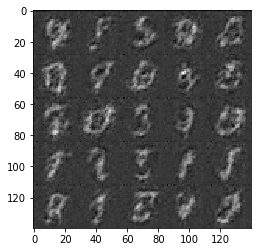

Epoch 5/10, Step 2050 ... Discriminator Loss: 0.0502... Generator Loss: 3.6799
Epoch 5/10, Step 2100 ... Discriminator Loss: 0.6134... Generator Loss: 1.1359
Epoch 5/10, Step 2150 ... Discriminator Loss: 0.8115... Generator Loss: 1.2265
Epoch 5/10, Step 2200 ... Discriminator Loss: 1.3845... Generator Loss: 0.4537
Epoch 5/10, Step 2250 ... Discriminator Loss: 0.2190... Generator Loss: 2.4965
Epoch 5/10, Step 2300 ... Discriminator Loss: 0.8659... Generator Loss: 1.0791
Epoch 6/10, Step 2350 ... Discriminator Loss: 0.8329... Generator Loss: 4.8832
Epoch 6/10, Step 2400 ... Discriminator Loss: 0.0913... Generator Loss: 3.0030
Epoch 6/10, Step 2450 ... Discriminator Loss: 0.0306... Generator Loss: 4.5868
Epoch 6/10, Step 2500 ... Discriminator Loss: 0.0310... Generator Loss: 4.1551


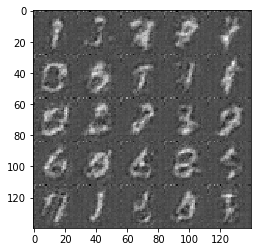

Epoch 6/10, Step 2550 ... Discriminator Loss: 0.0461... Generator Loss: 3.4781
Epoch 6/10, Step 2600 ... Discriminator Loss: 0.0304... Generator Loss: 3.8156
Epoch 6/10, Step 2650 ... Discriminator Loss: 0.0201... Generator Loss: 5.3653
Epoch 6/10, Step 2700 ... Discriminator Loss: 0.0679... Generator Loss: 2.9797
Epoch 6/10, Step 2750 ... Discriminator Loss: 0.0394... Generator Loss: 3.5410
Epoch 6/10, Step 2800 ... Discriminator Loss: 0.0029... Generator Loss: 7.5217
Epoch 7/10, Step 2850 ... Discriminator Loss: 1.0654... Generator Loss: 0.8559
Epoch 7/10, Step 2900 ... Discriminator Loss: 0.6428... Generator Loss: 1.2428
Epoch 7/10, Step 2950 ... Discriminator Loss: 0.3870... Generator Loss: 1.7663
Epoch 7/10, Step 3000 ... Discriminator Loss: 0.4559... Generator Loss: 2.1679


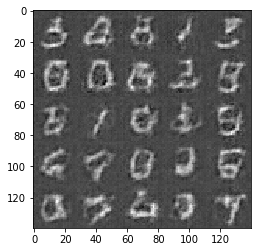

Epoch 7/10, Step 3050 ... Discriminator Loss: 0.2624... Generator Loss: 2.3851
Epoch 7/10, Step 3100 ... Discriminator Loss: 0.2777... Generator Loss: 2.4351
Epoch 7/10, Step 3150 ... Discriminator Loss: 0.2285... Generator Loss: 4.0180
Epoch 7/10, Step 3200 ... Discriminator Loss: 0.1197... Generator Loss: 2.9188
Epoch 7/10, Step 3250 ... Discriminator Loss: 0.1238... Generator Loss: 3.2897
Epoch 8/10, Step 3300 ... Discriminator Loss: 0.0501... Generator Loss: 3.5602
Epoch 8/10, Step 3350 ... Discriminator Loss: 0.0474... Generator Loss: 3.6867
Epoch 8/10, Step 3400 ... Discriminator Loss: 0.0362... Generator Loss: 3.8854
Epoch 8/10, Step 3450 ... Discriminator Loss: 0.0248... Generator Loss: 4.3682
Epoch 8/10, Step 3500 ... Discriminator Loss: 0.0399... Generator Loss: 3.7261


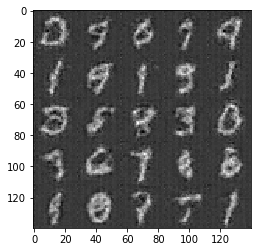

Epoch 8/10, Step 3550 ... Discriminator Loss: 0.0310... Generator Loss: 4.2783
Epoch 8/10, Step 3600 ... Discriminator Loss: 0.0207... Generator Loss: 4.3680
Epoch 8/10, Step 3650 ... Discriminator Loss: 0.0092... Generator Loss: 5.8995
Epoch 8/10, Step 3700 ... Discriminator Loss: 0.0187... Generator Loss: 4.5970
Epoch 9/10, Step 3750 ... Discriminator Loss: 0.5262... Generator Loss: 1.5453
Epoch 9/10, Step 3800 ... Discriminator Loss: 1.8580... Generator Loss: 0.2491
Epoch 9/10, Step 3850 ... Discriminator Loss: 0.1774... Generator Loss: 2.9666
Epoch 9/10, Step 3900 ... Discriminator Loss: 0.0397... Generator Loss: 3.7498
Epoch 9/10, Step 3950 ... Discriminator Loss: 0.1932... Generator Loss: 2.4372
Epoch 9/10, Step 4000 ... Discriminator Loss: 0.9513... Generator Loss: 3.0539


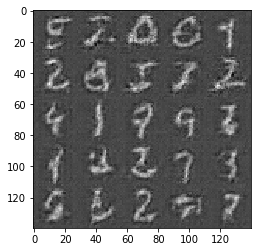

Epoch 9/10, Step 4050 ... Discriminator Loss: 0.8329... Generator Loss: 2.9906
Epoch 9/10, Step 4100 ... Discriminator Loss: 0.1049... Generator Loss: 3.0242
Epoch 9/10, Step 4150 ... Discriminator Loss: 0.0534... Generator Loss: 3.5082
Epoch 9/10, Step 4200 ... Discriminator Loss: 0.0667... Generator Loss: 3.2290
Epoch 10/10, Step 4250 ... Discriminator Loss: 0.0295... Generator Loss: 4.1771
Epoch 10/10, Step 4300 ... Discriminator Loss: 0.0503... Generator Loss: 3.4699
Epoch 10/10, Step 4350 ... Discriminator Loss: 0.0250... Generator Loss: 4.2321
Epoch 10/10, Step 4400 ... Discriminator Loss: 0.0945... Generator Loss: 2.6784
Epoch 10/10, Step 4450 ... Discriminator Loss: 0.0428... Generator Loss: 3.5790
Epoch 10/10, Step 4500 ... Discriminator Loss: 0.0542... Generator Loss: 3.3204


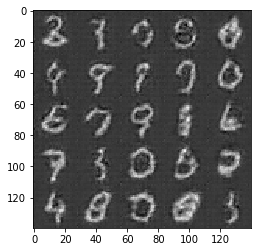

Epoch 10/10, Step 4550 ... Discriminator Loss: 0.0199... Generator Loss: 4.4325
Epoch 10/10, Step 4600 ... Discriminator Loss: 0.0111... Generator Loss: 4.9912
Epoch 10/10, Step 4650 ... Discriminator Loss: 1.0649... Generator Loss: 0.6481
Finished!


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
show_steps = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print("Finished!")

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/20, Step 0 ... Discriminator Loss: 2.9209... Generator Loss: 0.0910


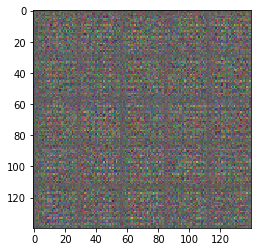

Epoch 1/20, Step 10 ... Discriminator Loss: 1.0373... Generator Loss: 0.9690
Epoch 1/20, Step 20 ... Discriminator Loss: 0.1272... Generator Loss: 3.4082
Epoch 1/20, Step 30 ... Discriminator Loss: 0.1418... Generator Loss: 10.9501
Epoch 1/20, Step 40 ... Discriminator Loss: 0.1748... Generator Loss: 4.0458
Epoch 1/20, Step 50 ... Discriminator Loss: 0.1017... Generator Loss: 5.3006
Epoch 1/20, Step 60 ... Discriminator Loss: 0.2899... Generator Loss: 2.1363
Epoch 1/20, Step 70 ... Discriminator Loss: 0.1529... Generator Loss: 3.1524
Epoch 1/20, Step 80 ... Discriminator Loss: 0.2567... Generator Loss: 2.2729
Epoch 1/20, Step 90 ... Discriminator Loss: 0.4003... Generator Loss: 2.4498
Epoch 1/20, Step 100 ... Discriminator Loss: 0.7958... Generator Loss: 0.9994


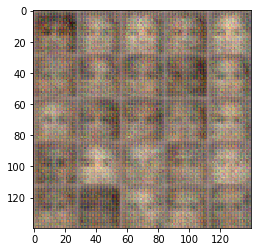

Epoch 1/20, Step 110 ... Discriminator Loss: 0.3199... Generator Loss: 2.0608
Epoch 1/20, Step 120 ... Discriminator Loss: 0.2357... Generator Loss: 2.0723
Epoch 1/20, Step 130 ... Discriminator Loss: 0.0688... Generator Loss: 3.9361
Epoch 1/20, Step 140 ... Discriminator Loss: 0.1438... Generator Loss: 2.9552
Epoch 1/20, Step 150 ... Discriminator Loss: 0.1308... Generator Loss: 3.0897
Epoch 1/20, Step 160 ... Discriminator Loss: 0.2073... Generator Loss: 2.7135
Epoch 1/20, Step 170 ... Discriminator Loss: 0.2980... Generator Loss: 2.0102
Epoch 1/20, Step 180 ... Discriminator Loss: 1.1988... Generator Loss: 1.2405
Epoch 1/20, Step 190 ... Discriminator Loss: 2.2597... Generator Loss: 0.3180
Epoch 1/20, Step 200 ... Discriminator Loss: 1.7906... Generator Loss: 0.3495


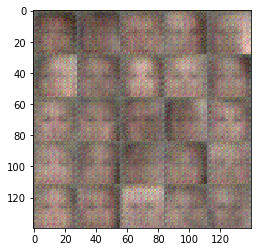

Epoch 1/20, Step 210 ... Discriminator Loss: 0.8871... Generator Loss: 2.2385
Epoch 1/20, Step 220 ... Discriminator Loss: 0.4800... Generator Loss: 3.2509
Epoch 1/20, Step 230 ... Discriminator Loss: 0.6018... Generator Loss: 2.1353
Epoch 1/20, Step 240 ... Discriminator Loss: 2.7365... Generator Loss: 5.8246
Epoch 1/20, Step 250 ... Discriminator Loss: 0.5147... Generator Loss: 1.5936
Epoch 1/20, Step 260 ... Discriminator Loss: 0.2586... Generator Loss: 11.1789
Epoch 1/20, Step 270 ... Discriminator Loss: 0.7349... Generator Loss: 1.5396
Epoch 1/20, Step 280 ... Discriminator Loss: 0.1400... Generator Loss: 2.9031
Epoch 1/20, Step 290 ... Discriminator Loss: 0.2579... Generator Loss: 2.9503
Epoch 1/20, Step 300 ... Discriminator Loss: 0.1717... Generator Loss: 4.3748


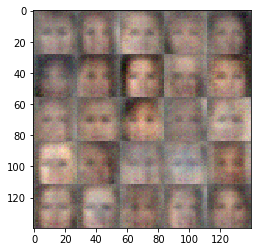

Epoch 1/20, Step 310 ... Discriminator Loss: 0.5629... Generator Loss: 1.4775
Epoch 1/20, Step 320 ... Discriminator Loss: 0.4539... Generator Loss: 14.5990
Epoch 1/20, Step 330 ... Discriminator Loss: 0.8727... Generator Loss: 10.7751
Epoch 1/20, Step 340 ... Discriminator Loss: 0.1751... Generator Loss: 7.5330
Epoch 1/20, Step 350 ... Discriminator Loss: 1.3096... Generator Loss: 0.4338
Epoch 1/20, Step 360 ... Discriminator Loss: 0.1057... Generator Loss: 8.4943
Epoch 1/20, Step 370 ... Discriminator Loss: 0.3818... Generator Loss: 1.3441
Epoch 1/20, Step 380 ... Discriminator Loss: 1.3360... Generator Loss: 0.3927
Epoch 1/20, Step 390 ... Discriminator Loss: 0.2776... Generator Loss: 13.1972
Epoch 1/20, Step 400 ... Discriminator Loss: 0.0607... Generator Loss: 4.9075


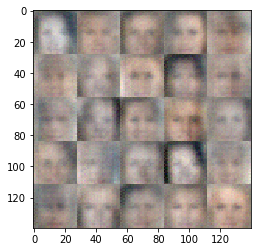

Epoch 1/20, Step 410 ... Discriminator Loss: 0.0202... Generator Loss: 9.8804
Epoch 1/20, Step 420 ... Discriminator Loss: 0.1058... Generator Loss: 3.4854
Epoch 1/20, Step 430 ... Discriminator Loss: 0.0224... Generator Loss: 5.5734
Epoch 1/20, Step 440 ... Discriminator Loss: 0.4100... Generator Loss: 1.2346
Epoch 1/20, Step 450 ... Discriminator Loss: 0.0510... Generator Loss: 8.7618
Epoch 1/20, Step 460 ... Discriminator Loss: 1.1900... Generator Loss: 0.4420
Epoch 1/20, Step 470 ... Discriminator Loss: 0.3410... Generator Loss: 7.6216
Epoch 1/20, Step 480 ... Discriminator Loss: 0.0221... Generator Loss: 6.7401
Epoch 1/20, Step 490 ... Discriminator Loss: 0.0468... Generator Loss: 9.5442
Epoch 1/20, Step 500 ... Discriminator Loss: 1.0493... Generator Loss: 12.5880


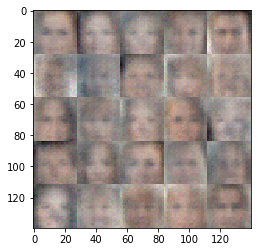

Epoch 1/20, Step 510 ... Discriminator Loss: 0.3277... Generator Loss: 4.0402
Epoch 1/20, Step 520 ... Discriminator Loss: 0.6091... Generator Loss: 0.8895
Epoch 1/20, Step 530 ... Discriminator Loss: 0.0337... Generator Loss: 6.9215
Epoch 1/20, Step 540 ... Discriminator Loss: 0.0414... Generator Loss: 4.8581
Epoch 1/20, Step 550 ... Discriminator Loss: 0.0123... Generator Loss: 11.2413
Epoch 1/20, Step 560 ... Discriminator Loss: 0.1718... Generator Loss: 2.0430
Epoch 1/20, Step 570 ... Discriminator Loss: 0.0218... Generator Loss: 6.5195
Epoch 1/20, Step 580 ... Discriminator Loss: 0.0142... Generator Loss: 8.1934
Epoch 1/20, Step 590 ... Discriminator Loss: 0.0300... Generator Loss: 6.0153
Epoch 1/20, Step 600 ... Discriminator Loss: 0.9859... Generator Loss: 0.5477


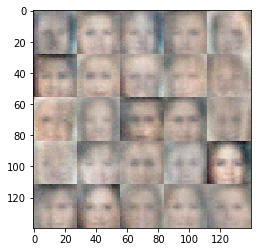

Epoch 1/20, Step 610 ... Discriminator Loss: 0.0110... Generator Loss: 6.0617
Epoch 1/20, Step 620 ... Discriminator Loss: 0.0330... Generator Loss: 11.6393
Epoch 1/20, Step 630 ... Discriminator Loss: 0.0237... Generator Loss: 10.4650
Epoch 1/20, Step 640 ... Discriminator Loss: 0.0087... Generator Loss: 11.7410
Epoch 1/20, Step 650 ... Discriminator Loss: 0.0151... Generator Loss: 6.1763
Epoch 1/20, Step 660 ... Discriminator Loss: 0.0371... Generator Loss: 13.0124
Epoch 1/20, Step 670 ... Discriminator Loss: 0.0525... Generator Loss: 7.9859
Epoch 1/20, Step 680 ... Discriminator Loss: 0.1256... Generator Loss: 2.5594
Epoch 1/20, Step 690 ... Discriminator Loss: 0.4302... Generator Loss: 1.1766
Epoch 1/20, Step 700 ... Discriminator Loss: 0.0111... Generator Loss: 7.3788


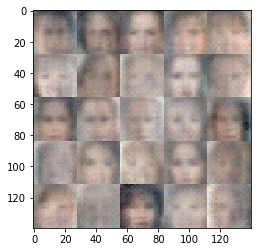

Epoch 1/20, Step 710 ... Discriminator Loss: 0.0101... Generator Loss: 12.2042
Epoch 1/20, Step 720 ... Discriminator Loss: 0.0075... Generator Loss: 14.9297
Epoch 1/20, Step 730 ... Discriminator Loss: 0.0150... Generator Loss: 11.1323
Epoch 1/20, Step 740 ... Discriminator Loss: 0.0760... Generator Loss: 12.4003
Epoch 1/20, Step 750 ... Discriminator Loss: 0.0179... Generator Loss: 9.5027
Epoch 1/20, Step 760 ... Discriminator Loss: 0.0174... Generator Loss: 13.1706
Epoch 1/20, Step 770 ... Discriminator Loss: 0.0109... Generator Loss: 7.3937
Epoch 1/20, Step 780 ... Discriminator Loss: 0.0109... Generator Loss: 5.6145
Epoch 1/20, Step 790 ... Discriminator Loss: 0.6642... Generator Loss: 2.8595
Epoch 1/20, Step 800 ... Discriminator Loss: 0.8550... Generator Loss: 0.9286


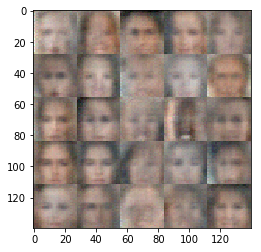

Epoch 1/20, Step 810 ... Discriminator Loss: 0.0553... Generator Loss: 3.6899
Epoch 1/20, Step 820 ... Discriminator Loss: 0.0340... Generator Loss: 14.0229
Epoch 1/20, Step 830 ... Discriminator Loss: 0.0143... Generator Loss: 5.8680
Epoch 1/20, Step 840 ... Discriminator Loss: 0.0536... Generator Loss: 3.3895
Epoch 1/20, Step 850 ... Discriminator Loss: 0.0267... Generator Loss: 4.6971
Epoch 1/20, Step 860 ... Discriminator Loss: 0.0084... Generator Loss: 8.5072
Epoch 1/20, Step 870 ... Discriminator Loss: 0.0135... Generator Loss: 10.4856
Epoch 1/20, Step 880 ... Discriminator Loss: 0.0075... Generator Loss: 9.3292
Epoch 1/20, Step 890 ... Discriminator Loss: 0.0072... Generator Loss: 12.1538
Epoch 1/20, Step 900 ... Discriminator Loss: 0.0603... Generator Loss: 3.0617


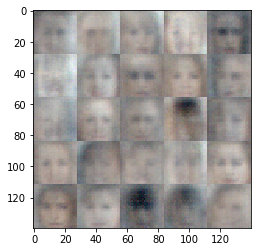

Epoch 1/20, Step 910 ... Discriminator Loss: 0.0260... Generator Loss: 13.5930
Epoch 1/20, Step 920 ... Discriminator Loss: 0.0130... Generator Loss: 7.8282
Epoch 1/20, Step 930 ... Discriminator Loss: 0.0079... Generator Loss: 11.7300
Epoch 1/20, Step 940 ... Discriminator Loss: 0.0180... Generator Loss: 13.0059
Epoch 1/20, Step 950 ... Discriminator Loss: 0.0074... Generator Loss: 8.5278
Epoch 1/20, Step 960 ... Discriminator Loss: 0.0107... Generator Loss: 5.3377
Epoch 1/20, Step 970 ... Discriminator Loss: 0.0189... Generator Loss: 4.4699
Epoch 1/20, Step 980 ... Discriminator Loss: 0.0035... Generator Loss: 7.5645
Epoch 1/20, Step 990 ... Discriminator Loss: 0.0130... Generator Loss: 4.9174
Epoch 1/20, Step 1000 ... Discriminator Loss: 0.0042... Generator Loss: 13.2637


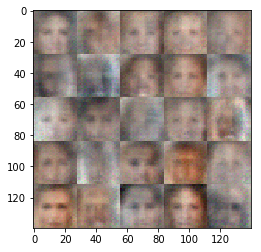

Epoch 1/20, Step 1010 ... Discriminator Loss: 0.0097... Generator Loss: 5.8861
Epoch 1/20, Step 1020 ... Discriminator Loss: 0.0195... Generator Loss: 14.9323
Epoch 1/20, Step 1030 ... Discriminator Loss: 0.0077... Generator Loss: 8.8160
Epoch 1/20, Step 1040 ... Discriminator Loss: 0.0065... Generator Loss: 7.4163
Epoch 1/20, Step 1050 ... Discriminator Loss: 0.0049... Generator Loss: 7.5927
Epoch 1/20, Step 1060 ... Discriminator Loss: 0.0059... Generator Loss: 11.9048
Epoch 1/20, Step 1070 ... Discriminator Loss: 0.0052... Generator Loss: 6.1251
Epoch 1/20, Step 1080 ... Discriminator Loss: 0.0072... Generator Loss: 7.4230
Epoch 1/20, Step 1090 ... Discriminator Loss: 0.0129... Generator Loss: 13.4717
Epoch 1/20, Step 1100 ... Discriminator Loss: 0.0050... Generator Loss: 10.5215


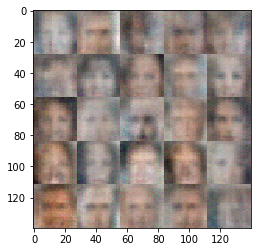

Epoch 1/20, Step 1110 ... Discriminator Loss: 0.0081... Generator Loss: 8.8634
Epoch 1/20, Step 1120 ... Discriminator Loss: 0.0058... Generator Loss: 9.4785
Epoch 1/20, Step 1130 ... Discriminator Loss: 0.0029... Generator Loss: 12.9718
Epoch 1/20, Step 1140 ... Discriminator Loss: 0.0099... Generator Loss: 6.6811
Epoch 1/20, Step 1150 ... Discriminator Loss: 0.0012... Generator Loss: 13.3324
Epoch 1/20, Step 1160 ... Discriminator Loss: 0.1063... Generator Loss: 2.8138
Epoch 1/20, Step 1170 ... Discriminator Loss: 0.0110... Generator Loss: 9.5732
Epoch 1/20, Step 1180 ... Discriminator Loss: 0.0944... Generator Loss: 2.6482
Epoch 1/20, Step 1190 ... Discriminator Loss: 0.0081... Generator Loss: 6.0699
Epoch 1/20, Step 1200 ... Discriminator Loss: 0.0111... Generator Loss: 8.7447


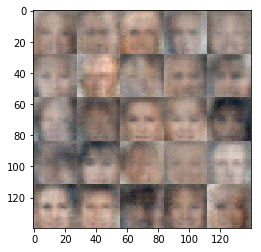

Epoch 1/20, Step 1210 ... Discriminator Loss: 0.0187... Generator Loss: 9.7285
Epoch 1/20, Step 1220 ... Discriminator Loss: 2.7225... Generator Loss: 0.1117
Epoch 1/20, Step 1230 ... Discriminator Loss: 0.0113... Generator Loss: 12.2288
Epoch 1/20, Step 1240 ... Discriminator Loss: 0.0393... Generator Loss: 3.6492
Epoch 1/20, Step 1250 ... Discriminator Loss: 0.2689... Generator Loss: 1.5391
Epoch 1/20, Step 1260 ... Discriminator Loss: 0.0216... Generator Loss: 7.6243
Epoch 1/20, Step 1270 ... Discriminator Loss: 0.0038... Generator Loss: 13.2839
Epoch 1/20, Step 1280 ... Discriminator Loss: 0.0085... Generator Loss: 10.5009
Epoch 1/20, Step 1290 ... Discriminator Loss: 0.0116... Generator Loss: 11.1776
Epoch 1/20, Step 1300 ... Discriminator Loss: 0.0156... Generator Loss: 11.4953


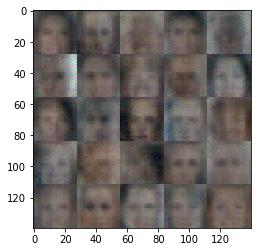

Epoch 1/20, Step 1310 ... Discriminator Loss: 0.0307... Generator Loss: 8.8428
Epoch 1/20, Step 1320 ... Discriminator Loss: 0.0074... Generator Loss: 6.6115
Epoch 1/20, Step 1330 ... Discriminator Loss: 0.0103... Generator Loss: 13.8070
Epoch 1/20, Step 1340 ... Discriminator Loss: 0.0049... Generator Loss: 12.3889
Epoch 1/20, Step 1350 ... Discriminator Loss: 0.0041... Generator Loss: 11.0702
Epoch 1/20, Step 1360 ... Discriminator Loss: 0.0023... Generator Loss: 9.4378
Epoch 1/20, Step 1370 ... Discriminator Loss: 0.0026... Generator Loss: 8.1270
Epoch 1/20, Step 1380 ... Discriminator Loss: 0.0020... Generator Loss: 8.1627
Epoch 1/20, Step 1390 ... Discriminator Loss: 0.0049... Generator Loss: 6.2603
Epoch 1/20, Step 1400 ... Discriminator Loss: 0.0022... Generator Loss: 8.4270


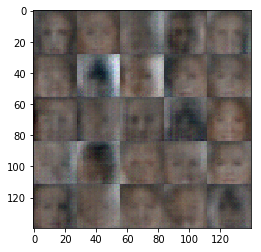

Epoch 1/20, Step 1410 ... Discriminator Loss: 0.0069... Generator Loss: 5.4804
Epoch 1/20, Step 1420 ... Discriminator Loss: 0.0364... Generator Loss: 8.7832
Epoch 1/20, Step 1430 ... Discriminator Loss: 0.0062... Generator Loss: 8.1869
Epoch 1/20, Step 1440 ... Discriminator Loss: 0.0044... Generator Loss: 11.0771
Epoch 1/20, Step 1450 ... Discriminator Loss: 0.0027... Generator Loss: 12.7139
Epoch 1/20, Step 1460 ... Discriminator Loss: 0.0034... Generator Loss: 11.9099
Epoch 1/20, Step 1470 ... Discriminator Loss: 0.0031... Generator Loss: 10.5718
Epoch 1/20, Step 1480 ... Discriminator Loss: 0.0030... Generator Loss: 10.5297
Epoch 1/20, Step 1490 ... Discriminator Loss: 0.2763... Generator Loss: 1.7768
Epoch 1/20, Step 1500 ... Discriminator Loss: 0.0044... Generator Loss: 12.2423


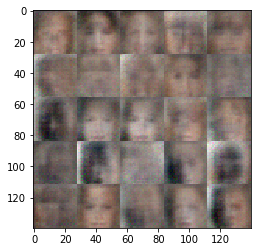

Epoch 1/20, Step 1510 ... Discriminator Loss: 0.0043... Generator Loss: 14.6241
Epoch 1/20, Step 1520 ... Discriminator Loss: 0.0035... Generator Loss: 9.6903
Epoch 1/20, Step 1530 ... Discriminator Loss: 0.0048... Generator Loss: 14.0471
Epoch 1/20, Step 1540 ... Discriminator Loss: 0.0053... Generator Loss: 8.6330
Epoch 1/20, Step 1550 ... Discriminator Loss: 0.0012... Generator Loss: 13.1931
Epoch 1/20, Step 1560 ... Discriminator Loss: 0.0020... Generator Loss: 8.2492
Epoch 1/20, Step 1570 ... Discriminator Loss: 0.0016... Generator Loss: 10.0846
Epoch 1/20, Step 1580 ... Discriminator Loss: 0.0016... Generator Loss: 13.3354
Epoch 2/20, Step 1590 ... Discriminator Loss: 0.0025... Generator Loss: 7.4290
Epoch 2/20, Step 1600 ... Discriminator Loss: 0.0024... Generator Loss: 7.1469


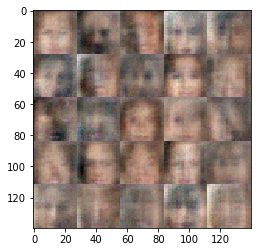

Epoch 2/20, Step 1610 ... Discriminator Loss: 0.0309... Generator Loss: 3.9082
Epoch 2/20, Step 1620 ... Discriminator Loss: 0.0044... Generator Loss: 8.4287
Epoch 2/20, Step 1630 ... Discriminator Loss: 0.0043... Generator Loss: 13.0648
Epoch 2/20, Step 1640 ... Discriminator Loss: 0.0016... Generator Loss: 10.6943
Epoch 2/20, Step 1650 ... Discriminator Loss: 0.0018... Generator Loss: 9.0486
Epoch 2/20, Step 1660 ... Discriminator Loss: 0.0019... Generator Loss: 8.2372
Epoch 2/20, Step 1670 ... Discriminator Loss: 0.0029... Generator Loss: 7.6830
Epoch 2/20, Step 1680 ... Discriminator Loss: 0.0016... Generator Loss: 7.7527
Epoch 2/20, Step 1690 ... Discriminator Loss: 0.0014... Generator Loss: 9.7059
Epoch 2/20, Step 1700 ... Discriminator Loss: 0.0014... Generator Loss: 8.6401


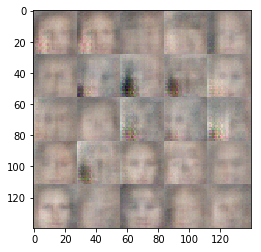

Epoch 2/20, Step 1710 ... Discriminator Loss: 0.0660... Generator Loss: 3.0361
Epoch 2/20, Step 1720 ... Discriminator Loss: 0.0012... Generator Loss: 11.1042
Epoch 2/20, Step 1730 ... Discriminator Loss: 0.0014... Generator Loss: 9.3320
Epoch 2/20, Step 1740 ... Discriminator Loss: 0.0027... Generator Loss: 7.9684
Epoch 2/20, Step 1750 ... Discriminator Loss: 0.0021... Generator Loss: 8.1147
Epoch 2/20, Step 1760 ... Discriminator Loss: 0.0019... Generator Loss: 7.7214
Epoch 2/20, Step 1770 ... Discriminator Loss: 0.0035... Generator Loss: 7.3277
Epoch 2/20, Step 1780 ... Discriminator Loss: 0.0016... Generator Loss: 10.4665
Epoch 2/20, Step 1790 ... Discriminator Loss: 0.0018... Generator Loss: 8.2214
Epoch 2/20, Step 1800 ... Discriminator Loss: 0.0015... Generator Loss: 7.8871


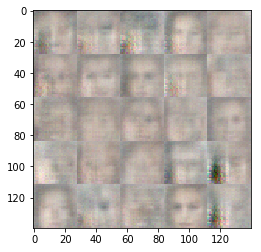

Epoch 2/20, Step 1810 ... Discriminator Loss: 0.0015... Generator Loss: 10.5051
Epoch 2/20, Step 1820 ... Discriminator Loss: 0.0013... Generator Loss: 9.0600
Epoch 2/20, Step 1830 ... Discriminator Loss: 0.0021... Generator Loss: 8.1155
Epoch 2/20, Step 1840 ... Discriminator Loss: 0.0539... Generator Loss: 3.4322
Epoch 2/20, Step 1850 ... Discriminator Loss: 0.0011... Generator Loss: 10.1084
Epoch 2/20, Step 1860 ... Discriminator Loss: 0.0013... Generator Loss: 9.2826
Epoch 2/20, Step 1870 ... Discriminator Loss: 0.0015... Generator Loss: 8.5371
Epoch 2/20, Step 1880 ... Discriminator Loss: 0.0025... Generator Loss: 7.8295
Epoch 2/20, Step 1890 ... Discriminator Loss: 0.0024... Generator Loss: 7.7293
Epoch 2/20, Step 1900 ... Discriminator Loss: 0.0033... Generator Loss: 7.3855


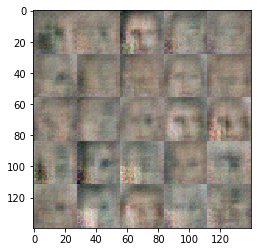

Epoch 2/20, Step 1910 ... Discriminator Loss: 0.0022... Generator Loss: 7.2400
Epoch 2/20, Step 1920 ... Discriminator Loss: 0.0024... Generator Loss: 6.4705
Epoch 2/20, Step 1930 ... Discriminator Loss: 0.0007... Generator Loss: 9.4009
Epoch 2/20, Step 1940 ... Discriminator Loss: 0.0013... Generator Loss: 10.2263
Epoch 2/20, Step 1950 ... Discriminator Loss: 0.0014... Generator Loss: 8.8874
Epoch 2/20, Step 1960 ... Discriminator Loss: 0.0018... Generator Loss: 7.5500
Epoch 2/20, Step 1970 ... Discriminator Loss: 0.0008... Generator Loss: 9.9528
Epoch 2/20, Step 1980 ... Discriminator Loss: 0.0009... Generator Loss: 9.1819
Epoch 2/20, Step 1990 ... Discriminator Loss: 0.0005... Generator Loss: 10.4206
Epoch 2/20, Step 2000 ... Discriminator Loss: 0.0013... Generator Loss: 11.5307


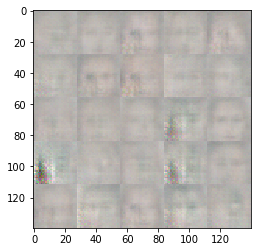

Epoch 2/20, Step 2010 ... Discriminator Loss: 0.0010... Generator Loss: 10.3623
Epoch 2/20, Step 2020 ... Discriminator Loss: 0.0010... Generator Loss: 8.7071
Epoch 2/20, Step 2030 ... Discriminator Loss: 0.0009... Generator Loss: 10.2266
Epoch 2/20, Step 2040 ... Discriminator Loss: 0.0015... Generator Loss: 8.0158
Epoch 2/20, Step 2050 ... Discriminator Loss: 0.0017... Generator Loss: 7.7540
Epoch 2/20, Step 2060 ... Discriminator Loss: 0.0008... Generator Loss: 9.0542
Epoch 2/20, Step 2070 ... Discriminator Loss: 0.0008... Generator Loss: 9.4846
Epoch 2/20, Step 2080 ... Discriminator Loss: 0.0176... Generator Loss: 4.7160
Epoch 2/20, Step 2090 ... Discriminator Loss: 0.0009... Generator Loss: 10.8849
Epoch 2/20, Step 2100 ... Discriminator Loss: 0.0006... Generator Loss: 9.7522


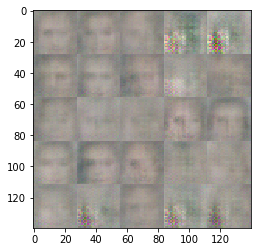

Epoch 2/20, Step 2110 ... Discriminator Loss: 0.0010... Generator Loss: 9.2800
Epoch 2/20, Step 2120 ... Discriminator Loss: 0.0012... Generator Loss: 8.8438
Epoch 2/20, Step 2130 ... Discriminator Loss: 0.0012... Generator Loss: 8.6881
Epoch 2/20, Step 2140 ... Discriminator Loss: 0.0017... Generator Loss: 8.1135
Epoch 2/20, Step 2150 ... Discriminator Loss: 0.0021... Generator Loss: 7.8614
Epoch 2/20, Step 2160 ... Discriminator Loss: 0.0008... Generator Loss: 11.2116
Epoch 2/20, Step 2170 ... Discriminator Loss: 0.0017... Generator Loss: 7.5139
Epoch 2/20, Step 2180 ... Discriminator Loss: 0.0007... Generator Loss: 9.3322
Epoch 2/20, Step 2190 ... Discriminator Loss: 0.0006... Generator Loss: 11.1626
Epoch 2/20, Step 2200 ... Discriminator Loss: 0.0008... Generator Loss: 9.3435


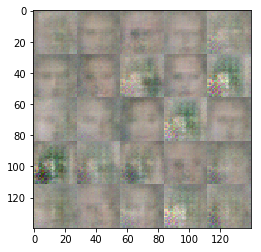

Epoch 2/20, Step 2210 ... Discriminator Loss: 0.0019... Generator Loss: 7.4842
Epoch 2/20, Step 2220 ... Discriminator Loss: 0.0003... Generator Loss: 10.7053
Epoch 2/20, Step 2230 ... Discriminator Loss: 0.0014... Generator Loss: 8.2034
Epoch 2/20, Step 2240 ... Discriminator Loss: 0.0006... Generator Loss: 9.0668
Epoch 2/20, Step 2250 ... Discriminator Loss: 0.0013... Generator Loss: 11.4079
Epoch 2/20, Step 2260 ... Discriminator Loss: 0.0012... Generator Loss: 9.5511
Epoch 2/20, Step 2270 ... Discriminator Loss: 0.0014... Generator Loss: 7.4185
Epoch 2/20, Step 2280 ... Discriminator Loss: 0.0023... Generator Loss: 7.5427
Epoch 2/20, Step 2290 ... Discriminator Loss: 0.0006... Generator Loss: 8.7592
Epoch 2/20, Step 2300 ... Discriminator Loss: 0.0008... Generator Loss: 10.5628


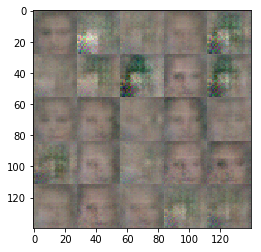

Epoch 2/20, Step 2310 ... Discriminator Loss: 0.0010... Generator Loss: 10.4124
Epoch 2/20, Step 2320 ... Discriminator Loss: 0.0007... Generator Loss: 11.1079
Epoch 2/20, Step 2330 ... Discriminator Loss: 0.0008... Generator Loss: 10.6329
Epoch 2/20, Step 2340 ... Discriminator Loss: 0.0009... Generator Loss: 9.0725
Epoch 2/20, Step 2350 ... Discriminator Loss: 0.0013... Generator Loss: 8.4109
Epoch 2/20, Step 2360 ... Discriminator Loss: 0.0006... Generator Loss: 11.9951
Epoch 2/20, Step 2370 ... Discriminator Loss: 0.0004... Generator Loss: 10.5621
Epoch 2/20, Step 2380 ... Discriminator Loss: 0.0008... Generator Loss: 9.4134
Epoch 2/20, Step 2390 ... Discriminator Loss: 0.0006... Generator Loss: 10.8402
Epoch 2/20, Step 2400 ... Discriminator Loss: 0.0005... Generator Loss: 11.4986


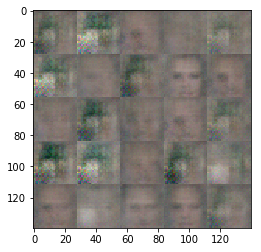

Epoch 2/20, Step 2410 ... Discriminator Loss: 0.0010... Generator Loss: 8.9819
Epoch 2/20, Step 2420 ... Discriminator Loss: 0.0010... Generator Loss: 8.4018
Epoch 2/20, Step 2430 ... Discriminator Loss: 0.0014... Generator Loss: 7.7694
Epoch 2/20, Step 2440 ... Discriminator Loss: 0.0012... Generator Loss: 7.5296
Epoch 2/20, Step 2450 ... Discriminator Loss: 0.0014... Generator Loss: 7.7581
Epoch 2/20, Step 2460 ... Discriminator Loss: 0.0014... Generator Loss: 7.5486
Epoch 2/20, Step 2470 ... Discriminator Loss: 0.0018... Generator Loss: 7.2555
Epoch 2/20, Step 2480 ... Discriminator Loss: 0.0014... Generator Loss: 7.5616
Epoch 2/20, Step 2490 ... Discriminator Loss: 0.0017... Generator Loss: 7.6817
Epoch 2/20, Step 2500 ... Discriminator Loss: 0.0015... Generator Loss: 7.7637


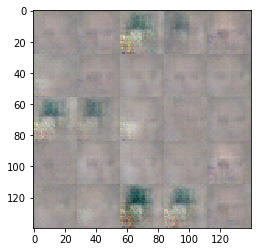

Epoch 2/20, Step 2510 ... Discriminator Loss: 0.0022... Generator Loss: 6.9833
Epoch 2/20, Step 2520 ... Discriminator Loss: 0.0018... Generator Loss: 7.2018
Epoch 2/20, Step 2530 ... Discriminator Loss: 0.0013... Generator Loss: 7.4610
Epoch 2/20, Step 2540 ... Discriminator Loss: 0.0015... Generator Loss: 7.2760
Epoch 2/20, Step 2550 ... Discriminator Loss: 0.0017... Generator Loss: 7.3536
Epoch 2/20, Step 2560 ... Discriminator Loss: 0.0012... Generator Loss: 7.9830
Epoch 2/20, Step 2570 ... Discriminator Loss: 0.0012... Generator Loss: 7.8308
Epoch 2/20, Step 2580 ... Discriminator Loss: 0.0013... Generator Loss: 7.8108
Epoch 2/20, Step 2590 ... Discriminator Loss: 0.0012... Generator Loss: 7.4351
Epoch 2/20, Step 2600 ... Discriminator Loss: 0.0011... Generator Loss: 7.7748


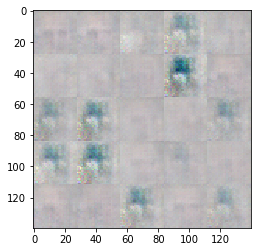

Epoch 2/20, Step 2610 ... Discriminator Loss: 0.0008... Generator Loss: 8.0258
Epoch 2/20, Step 2620 ... Discriminator Loss: 0.0016... Generator Loss: 7.2670
Epoch 2/20, Step 2630 ... Discriminator Loss: 0.0014... Generator Loss: 7.7644
Epoch 2/20, Step 2640 ... Discriminator Loss: 0.0010... Generator Loss: 7.7937
Epoch 2/20, Step 2650 ... Discriminator Loss: 0.0027... Generator Loss: 7.2244
Epoch 2/20, Step 2660 ... Discriminator Loss: 0.0017... Generator Loss: 7.4662
Epoch 2/20, Step 2670 ... Discriminator Loss: 0.0018... Generator Loss: 7.6084
Epoch 2/20, Step 2680 ... Discriminator Loss: 0.0021... Generator Loss: 7.1919
Epoch 2/20, Step 2690 ... Discriminator Loss: 0.0017... Generator Loss: 7.8796
Epoch 2/20, Step 2700 ... Discriminator Loss: 0.0014... Generator Loss: 7.9254


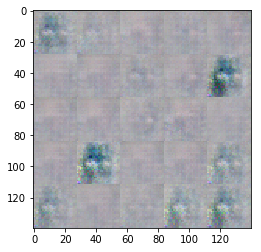

Epoch 2/20, Step 2710 ... Discriminator Loss: 0.0012... Generator Loss: 8.2146
Epoch 2/20, Step 2720 ... Discriminator Loss: 0.0019... Generator Loss: 7.4639
Epoch 2/20, Step 2730 ... Discriminator Loss: 0.0014... Generator Loss: 7.8110
Epoch 2/20, Step 2740 ... Discriminator Loss: 0.0025... Generator Loss: 7.0573
Epoch 2/20, Step 2750 ... Discriminator Loss: 0.0009... Generator Loss: 8.2575
Epoch 2/20, Step 2760 ... Discriminator Loss: 0.0012... Generator Loss: 7.8916
Epoch 2/20, Step 2770 ... Discriminator Loss: 0.0020... Generator Loss: 7.3210
Epoch 2/20, Step 2780 ... Discriminator Loss: 0.0019... Generator Loss: 7.3240
Epoch 2/20, Step 2790 ... Discriminator Loss: 0.0014... Generator Loss: 7.7783
Epoch 2/20, Step 2800 ... Discriminator Loss: 0.0015... Generator Loss: 7.7807


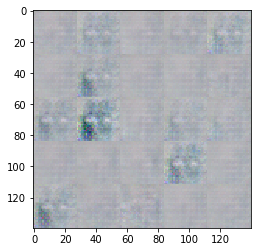

Epoch 2/20, Step 2810 ... Discriminator Loss: 0.0016... Generator Loss: 7.4906
Epoch 2/20, Step 2820 ... Discriminator Loss: 0.0016... Generator Loss: 7.7374
Epoch 2/20, Step 2830 ... Discriminator Loss: 0.0017... Generator Loss: 7.6741
Epoch 2/20, Step 2840 ... Discriminator Loss: 0.0009... Generator Loss: 7.9828
Epoch 2/20, Step 2850 ... Discriminator Loss: 0.0006... Generator Loss: 8.7263


KeyboardInterrupt: 

In [15]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
show_steps = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 20


celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.